# GOBS functional connectivity analysis


In [144]:
import pickle,os
import numpy,pandas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import nibabel
import networkx
import scipy.stats
from matplotlib.colors import LinearSegmentedColormap


nrois=374
scrub_thresh=0.2

def r_to_z(r):
    # fisher transform
    z=0.5*numpy.log((1.0+r)/(1.0-r))
    z[numpy.where(numpy.isinf(z))]=0
    z[numpy.where(numpy.isnan(z))]=0
    
    return z


def z_to_r(z):
    # inverse transform
    return (numpy.exp(2.0*z) - 1)/(numpy.exp(2.0*z) + 1)



In [145]:
basedir = '/Users/poldrack/data_unsynced/GOBS/roidata'
corrdict=pickle.load(open(os.path.join(basedir,'corrs.pkl'),'rb'))


360

In [155]:
nsubs=len(corrdict)
subcodes=[i for i in corrdict.keys()]
corrdata={'GSR':numpy.zeros((len(subcodes),corrdict[subcodes[0]]['GSR'].shape[0])),
          'noGSR':numpy.zeros((len(subcodes),corrdict[subcodes[0]]['noGSR'].shape[0])),
          'GSR+scrub':numpy.zeros((len(subcodes),corrdict[subcodes[0]]['GSR+scrub'].shape[0]))}

# get atlas labels from a data file
roidata=pandas.read_csv(os.path.join(basedir,subcodes[0],'func/roidata.confound_resid_GSR.txt'),
                        sep='\t')
atlaslabels=roidata.columns.tolist()

# get mean correlations
meancorr={}
sdcorr={}
meancorrmtx={}
graphs={}
datatypes=['GSR','GSR+scrub','noGSR']

for datatype in datatypes:
    ctr=0
    for i,subcode in enumerate(subcodes):
        # convert to z scores since we will averaging
        if corrdict[subcode]['nscrubbed']<150*scrub_thresh:
            corrdata[datatype][ctr,:]=r_to_z(corrdict[subcode][datatype])
            ctr+=1
    corrdata[datatype]=corrdata[datatype][:ctr,:]
    # convert back to r
    meancorr[datatype]=z_to_r(numpy.mean(corrdata[datatype],0))
    sdcorr[datatype]=numpy.std(corrdata[datatype],0)

    meancorrmtx[datatype]=numpy.zeros((nrois,nrois))
    meancorrmtx[datatype][numpy.triu_indices(nrois,1)]=meancorr[datatype]
    meancorrmtx[datatype]=meancorrmtx[datatype]+meancorrmtx[datatype].T
    meancorrmtx[datatype]=pandas.DataFrame(meancorrmtx[datatype],
                                        columns=atlaslabels,
                                          index=atlaslabels)
    thresh=scipy.stats.scoreatpercentile(meancorr[datatype],100-graph_density*100)
    

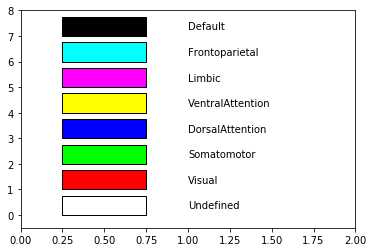

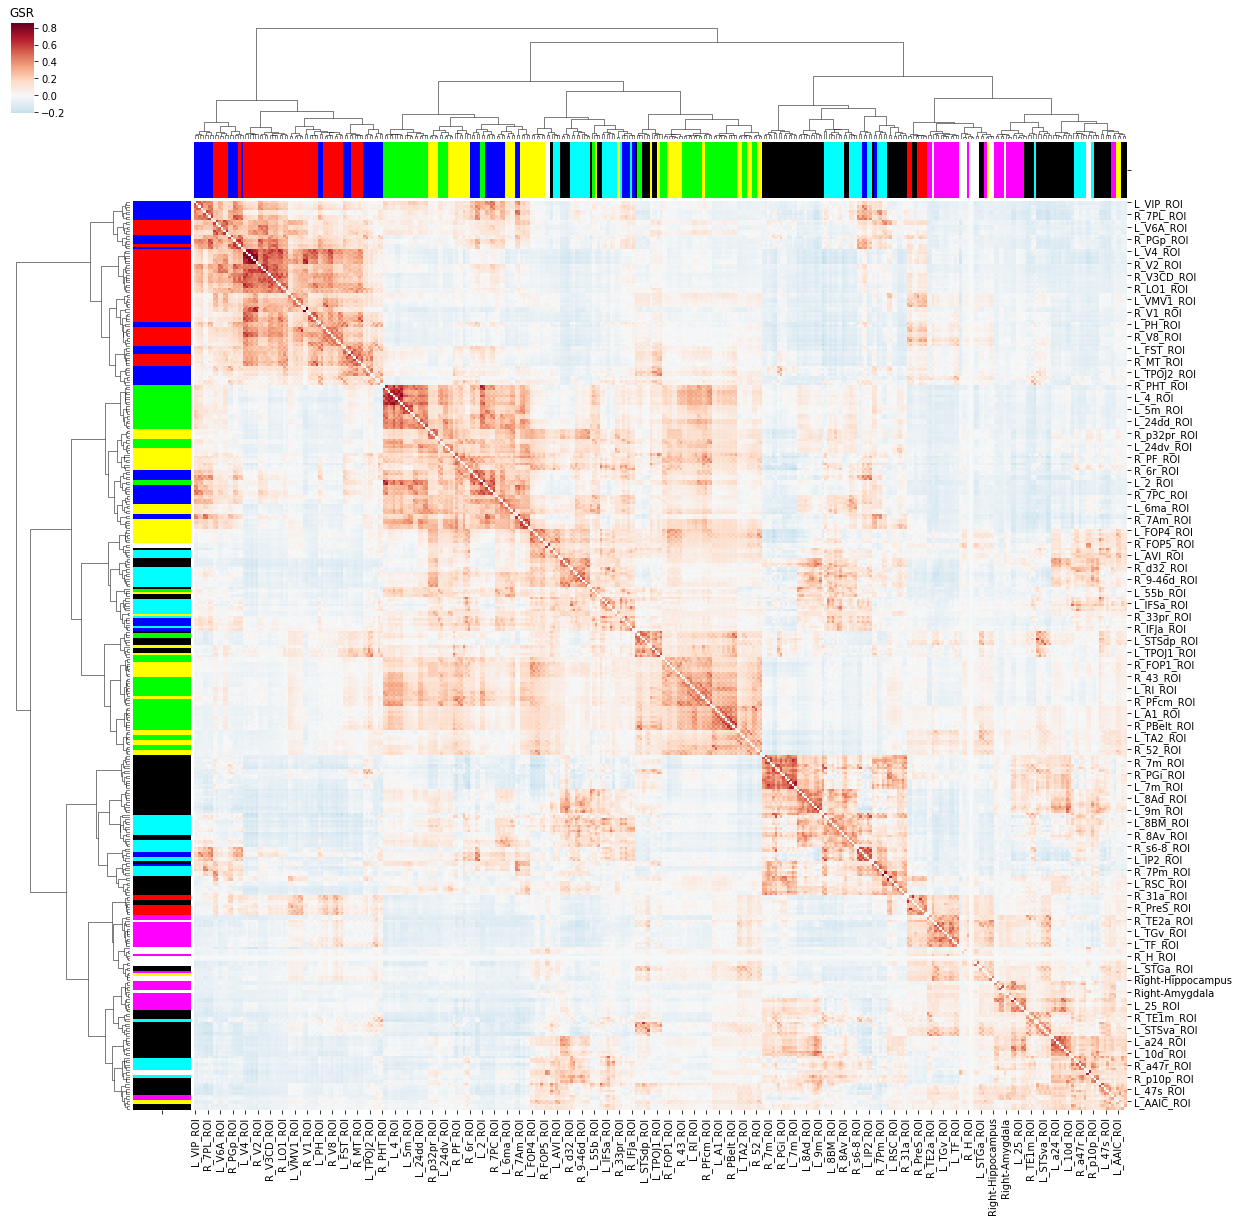

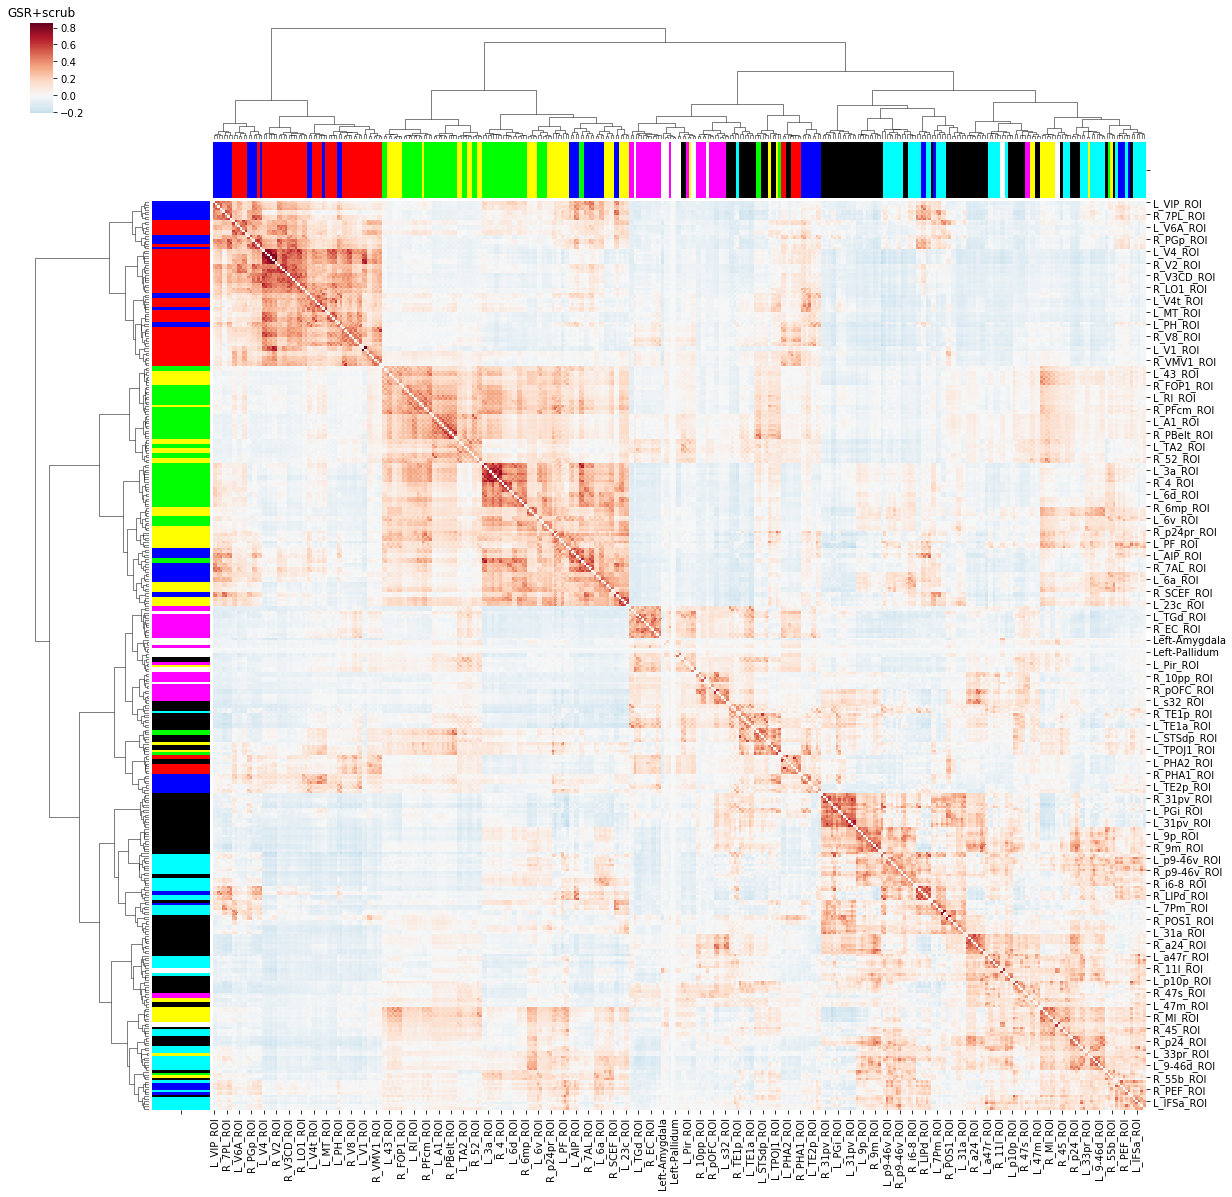

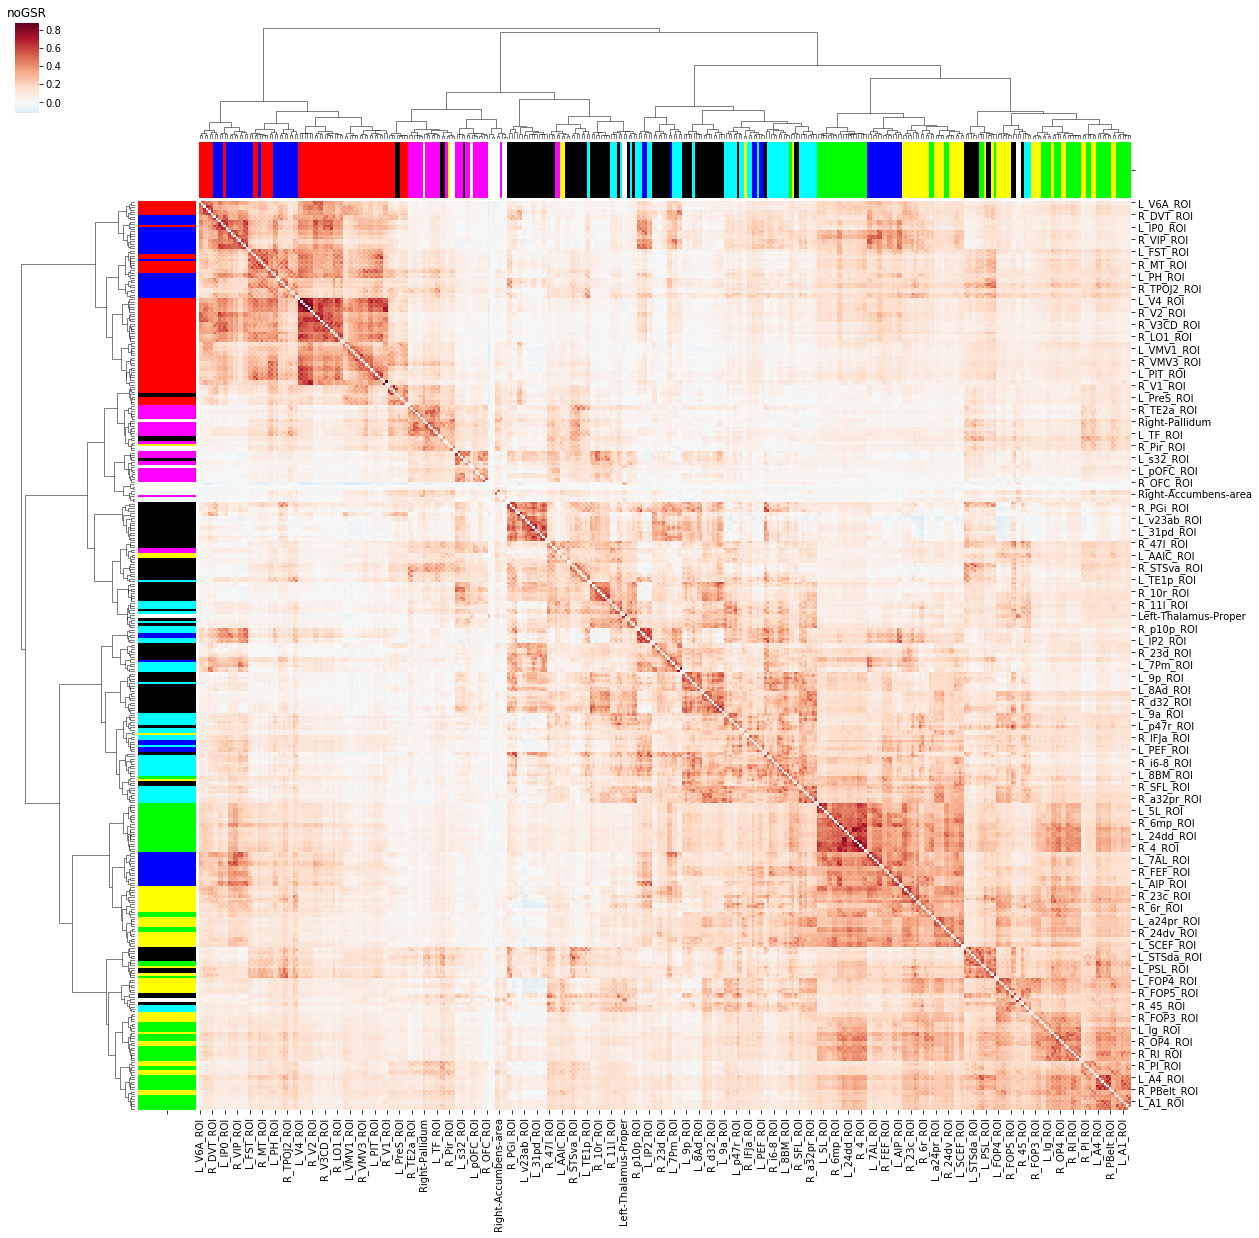

In [219]:
# load yeo labels
yeodata=pandas.read_csv('../extract/HCP-MMP1/MMP_yeo2011_7networks.csv')
yeolabels=yeodata['Yeo']
yeolabels=yeolabels.append(pandas.Series(numpy.ones(14)*8))
yeolabels.index=meancorrmtx['GSR+scrub'].index
yeodict={}
for i in range(yeodata.shape[0]):
    yeodict[yeodata.iloc[i,2]]=yeodata.iloc[i,3]
yeodesc=[yeodict[i] for i in numpy.arange(8)]

# Create a categorical palette to identify the networks
network_pal = seaborn.color_palette("hls", 8)
network_lut = dict(zip(range(8), network_pal))
network_lut={0:(1,1,1),
            1:(1,0,0),
            2:(0,1,0),
            3:(0,0,1),
            4:(1,1,0),
            5:(1,0,1),
            6:(0,1,1),
            7:(0,0,0)}
network_colors = yeolabels.map(network_lut)

# make legend for color map
plt.figure()
plt.axis([0,2,-0.5,8])
ax=plt.gca()
for i in range(8):
    rect=plt.Rectangle((0.25,i),0.5,0.75,facecolor=network_lut[i],
                       edgecolor='black',linewidth=1)
    ax.add_patch(rect)
    plt.text(1,i+0.25,yeodesc[i])
    
# plot cluster maps

for datatype in datatypes:
    seaborn.clustermap(meancorrmtx[datatype],method='ward',
                  row_colors=network_colors, col_colors=network_colors,
                  figsize=(20,20),cmap="RdBu_r",center=0)
    plt.title(datatype)
